# **Final Project: Detecting Bone Fractures in Musculoskeletal Radiographs**
Team 1: Sarah Barron, Haeun Lee, and Camryn Lewis

## Package Import and Data Import

Import Packages

In [ ]:
# Import necessary packages
import keras
import tensorflow as tf
from skimage.io import imshow
from pathlib import Path
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from glob import glob
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import metrics
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import roc_curve, roc_auc_score

Import Data

In [ ]:
# Pull data from kaggle (saved as a private dataset)
os.environ['KAGGLE_USERNAME'] = "sarahbarron" # username from the json file
os.environ['KAGGLE_KEY'] = "5329766b482e9eec8b905e1a82036269" # key from the json file
!kaggle datasets download -d sarahbarron/mura-dataset # api copied from kaggle

 99% 3.13G/3.14G [02:06<00:01, 14.1MB/s]
100% 3.14G/3.14G [02:06<00:00, 26.6MB/s]


In [ ]:
# Unzip file
!unzip -q 'mura-dataset.zip' 

## Data Exploration and Pre-Processing

Defining Path Data Frames

In [ ]:
# Define root path
dataset_root = Path('MURA-v1.1')

In [ ]:
# Create data frame of training data paths and display head
train_paths = pd.read_csv(dataset_root/'train_image_paths.csv', header=None, names=['filename'])
train_paths['class'] = (train_paths.filename.str.extract('study.*_(positive|negative)'))
train_paths.head()

,filename,class
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive


Data Exploration

In [ ]:
# Pull classes from data paths
train_df = pd.read_csv(dataset_root/'train_image_paths.csv', header=None, names=['filename'])
train_df['class'] = (train_df.filename.str.extract('study.*_(positive|negative)'))

def category(path):
  expected_output = path.split('/')[2].split("_")[1]
  return(expected_output)

# Pull category and patientID from data paths
train_df['category'] = train_df['filename'].apply(lambda x: category(x))
train_df['patientId'] = train_df['filename'].apply(lambda x: x.split('/')[3].replace('patient', ''))

# Display dataframe head
train_df.head()


,filename,class,category,patientId
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,SHOULDER,00001
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,SHOULDER,00001
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive,SHOULDER,00001
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,SHOULDER,00002
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive,SHOULDER,00002


In [ ]:
# Create data frame of test data paths and display head (denoted as validation from MURA dataset)
test_paths = pd.read_csv(dataset_root/'valid_image_paths.csv', header=None, names=['filename'])
test_paths['class'] = (test_paths.filename.str.extract('study.*_(positive|negative)'))
test_paths.head()

,filename,class
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,positive
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,positive


Display Sample Images

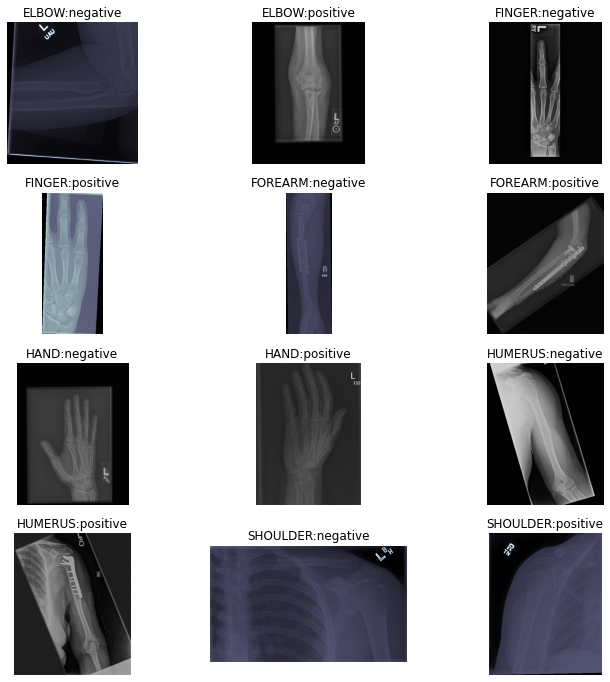

In [ ]:
# Display 12 sample images
sub_df = train_df.groupby(['category', 'class']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(4, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['filename']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{category}:{class}'.format(**c_row))
fig.savefig('samples.png', dpi = 300)

Pre-Processing

In [ ]:
# Generate batches of tensor image data from the filepath data frames

# Define ImageDataGenerator functions for training and test data
# Training function scales the image and defines validation set size
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split=0.3) 
# Test function scales only
test_datagen = ImageDataGenerator(rescale = 1./255)

# Define image size for re-sizing
image_size = 320

# Define functions to generate datasets from image files in the directory
train_gen = train_datagen.flow_from_dataframe(train_paths,
                                              directory = None,
                                              target_size = (image_size, image_size),
                                              class_mode = 'binary', 
                                              subset = 'training',
                                              )

val_gen = train_datagen.flow_from_dataframe(train_paths,
                                        directory=None,
                                        target_size = (image_size, image_size),
                                        class_mode = 'binary', 
                                        subset = 'validation',
                                        )

test_gen = test_datagen.flow_from_dataframe(test_paths,
                                       directory=None,
                                       target_size = (image_size, image_size),
                                       class_mode = 'binary',
                                       shuffle = False
                                       )

# Print class indices to verify classes are correct
print(train_gen.class_indices)
print(val_gen.class_indices)
print(test_gen.class_indices)

Found 25766 validated image filenames belonging to 2 classes.
Found 11042 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.
{'negative': 0, 'positive': 1}
{'negative': 0, 'positive': 1}
{'negative': 0, 'positive': 1}


## Model Development

Build Model using DenseNet-169 as Base Model

Standard DenseNet-169 Architecture: [1]

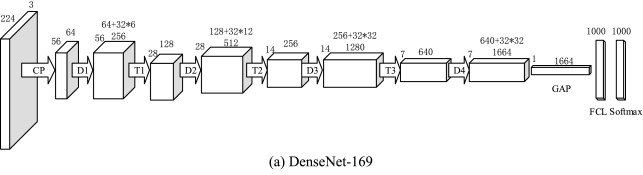

To start the training process, the base model was initialized with weights pre-trained on ImageNet, a large computer vision database. 

In [ ]:
# Pull the base model (DenseNet-169)
# Weights = 'imagenet' indicate that the DenseNet is being pre-trained using imagenet
densenet = tf.keras.applications.DenseNet169(weights='imagenet', include_top = False, input_shape = (320,320,3))

In [ ]:
# Freeze the base model - this will be fine-tuned later
densenet.trainable = False

In [ ]:
# Build full model
model = tf.keras.models.Sequential([densenet,
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(1, activation = 'sigmoid')])


In [ ]:
# Display model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 10, 10, 1664)      12642880  
_________________________________________________________________
flatten_1 (Flatten)          (None, 166400)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 166401    
Total params: 12,809,281
Trainable params: 166,401
Non-trainable params: 12,642,880
_________________________________________________________________


Compile the Model

In [ ]:
# Model compilation
# Set learning rate in optimizer input. The default is 0.001.
model.compile(loss = tf.keras.losses.binary_crossentropy,
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])


Train the Model

In [ ]:
# Define number of epochs and batch sizes
epochs = 30
batch_size = 32


# Train the model
history = model.fit(train_gen,
          steps_per_epoch = train_gen.samples//batch_size,
          validation_data = val_gen,
          validation_steps = val_gen.samples//batch_size,
          epochs = epochs,
          workers = 16,
          verbose=1,
          shuffle=True)

# Save the model after training
model.save("my_model")

Epoch 1/30
805/805 [==============================] - 531s 659ms/step - loss: 1.8049 - accuracy: 0.7150 - val_loss: 3.4251 - val_accuracy: 0.5563
Epoch 2/30
805/805 [==============================] - 526s 653ms/step - loss: 1.4711 - accuracy: 0.7822 - val_loss: 4.8578 - val_accuracy: 0.5259
Epoch 3/30
805/805 [==============================] - 527s 655ms/step - loss: 1.3536 - accuracy: 0.8094 - val_loss: 4.8094 - val_accuracy: 0.5414
Epoch 4/30
805/805 [==============================] - 527s 655ms/step - loss: 1.1671 - accuracy: 0.8335 - val_loss: 6.7723 - val_accuracy: 0.5469
Epoch 5/30
805/805 [==============================] - 526s 654ms/step - loss: 1.1038 - accuracy: 0.8454 - val_loss: 7.1638 - val_accuracy: 0.5266
Epoch 6/30
805/805 [==============================] - 527s 654ms/step - loss: 0.8541 - accuracy: 0.8671 - val_loss: 6.1102 - val_accuracy: 0.5451
Epoch 7/30
805/805 [==============================] - 528s 655ms/step - loss: 0.9098 - accuracy: 0.8680 - val_loss: 6.7104 -

Plot Learning Curves

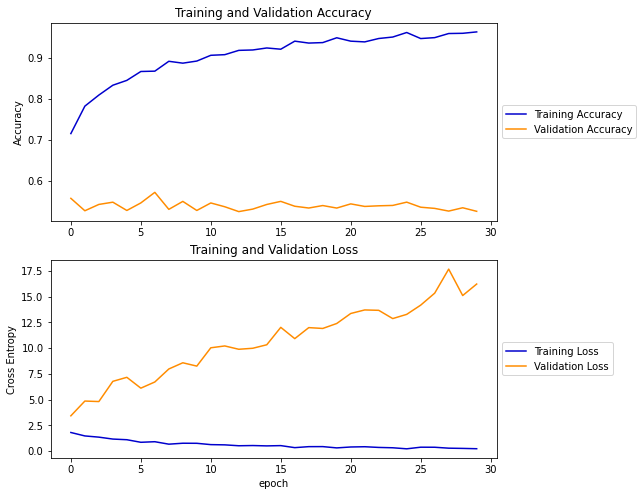

In [ ]:
# Pull accuracy and loss values from model history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Accuracy Plot
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color = 'mediumblue')
plt.plot(val_acc, label='Validation Accuracy', color = 'darkorange')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color = 'mediumblue')
plt.plot(val_loss, label='Validation Loss', color = 'darkorange')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


## Fine-Tuning The Model

After pre-training, the weights were fine-tuned. Pre-training, followed by fine-tuning, reduces the time it takes for the model to converge and helps regularize the model to reduce overfitting.

In [ ]:
#Un-freezing the base model
densenet.trainable = True

In [ ]:
#Fine-tune the model from this layer onward
fine_tune_at = 100

#Freeze all layers before the "fine_tune_at" layer
for layer in densenet.layers[:fine_tune_at:]:
  layer.trainable = False


Re-Compile the Model

In [ ]:
#Compile the model with a much lower learning rate
model.compile(loss = tf.keras.losses.binary_crossentropy,
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics = ['accuracy'])

# Display model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 10, 10, 1664)      12642880  
_________________________________________________________________
flatten_1 (Flatten)          (None, 166400)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 166401    
Total params: 12,809,281
Trainable params: 11,846,209
Non-trainable params: 963,072
_________________________________________________________________


Continue to train the model

In [ ]:
# Define number of epochs and batch size
epochs = 10
batch_size = 64

# Continue model training
history_fine = model.fit(train_gen,
          steps_per_epoch = train_gen.samples//batch_size,
          validation_data = val_gen,
          validation_steps = val_gen.samples//batch_size,
          epochs = epochs,
          workers = 16,
          verbose=1,
          shuffle=True)

# Save the model after training
model.save("fine_model")

Epoch 1/10
402/402 [==============================] - 524s 1s/step - loss: 11.4646 - accuracy: 0.7350 - val_loss: 25.9753 - val_accuracy: 0.5362
Epoch 2/10
402/402 [==============================] - 525s 1s/step - loss: 6.1037 - accuracy: 0.8180 - val_loss: 25.2629 - val_accuracy: 0.5303
Epoch 3/10
402/402 [==============================] - 523s 1s/step - loss: 3.9167 - accuracy: 0.8608 - val_loss: 23.5259 - val_accuracy: 0.5463
Epoch 4/10
402/402 [==============================] - 523s 1s/step - loss: 2.7197 - accuracy: 0.8847 - val_loss: 23.9814 - val_accuracy: 0.5476
Epoch 5/10
402/402 [==============================] - 523s 1s/step - loss: 1.9861 - accuracy: 0.9068 - val_loss: 23.4567 - val_accuracy: 0.5429
Epoch 6/10
402/402 [==============================] - 523s 1s/step - loss: 1.4472 - accuracy: 0.9282 - val_loss: 22.4435 - val_accuracy: 0.5456
Epoch 7/10
402/402 [==============================] - 522s 1s/step - loss: 1.0795 - accuracy: 0.9405 - val_loss: 23.4230 - val_accuracy

Plot Updated Learning Curves

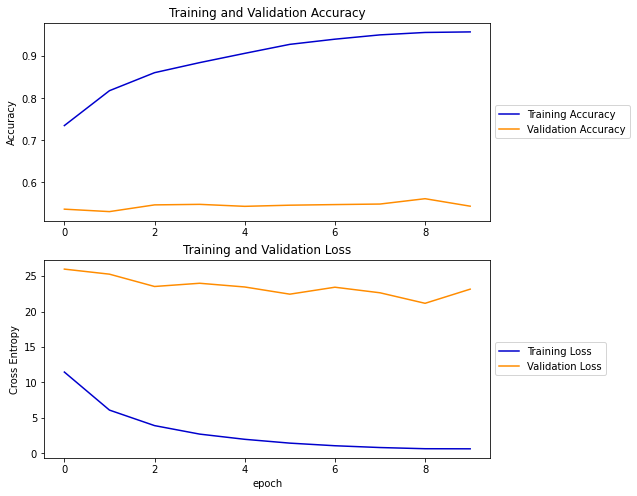

In [ ]:
# Pull accuracy and loss values from model history
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

# Accuracy Plot
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color = 'mediumblue')
plt.plot(val_acc, label='Validation Accuracy', color = 'darkorange')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Loss Plot
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color = 'mediumblue')
plt.plot(val_loss, label='Validation Loss', color = 'darkorange')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


## Evaluation on Test Data

Model Evaluation

In [ ]:
# Evaluate the model using test dataset
scores = model.evaluate(test_gen)

100/100 [==============================] - 44s 443ms/step - loss: 14.3606 - accuracy: 0.6891


Display Confusion Matrix

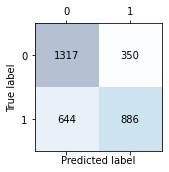

In [ ]:
# Perform model classifiation predictions and calculate confusion matrix
y_pred = model.predict_classes(test_gen)
confmat = confusion_matrix(test_gen.classes, y_pred)

# Display confusion matrix
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

Plot ROC curve

Text(0, 0.5, 'True Positive Rate')

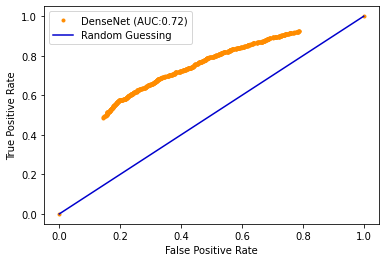

In [ ]:
# Perform model predictions
Y_pred = model.predict(test_gen)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(test_gen.classes, Y_pred)
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, '.', label = 'DenseNet (AUC:%2.2f)' % roc_auc_score(test_gen.classes, Y_pred), color = 'darkorange')
ax1.plot(fpr, fpr, '-', label = 'Random Guessing', color = 'mediumblue')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')

## References


[1] Wang, S. H., & Zhang, Y. D. (2020). DenseNet-201-based deep neural network with composite learning factor and precomputation for multiple sclerosis classification. ACM Transactions on Multimedia Computing, Communications, and Applications (TOMM), 16(2s), 1-19.